# Roto-translation equivariance

This notebook demos the rotation equivariance property of a simple 2 layer G-CNN. It demonstrates how to use the functions ConvRnG (lifting convolution) and ConvGG (group convolution). Just because it is possible we change the resolution in the rotation dimension between the layers (first layer samples for 16 rotations, the second only for 8).

-----------------------
## Importing libraries

Add the library to the system path via the relative folder structure:

In [1]:
import os,sys
splinets_source =  os.path.join(os.getcwd(),'..')
if splinets_source not in sys.path:
    sys.path.append(splinets_source)

Import below the gsplinets library with a specified group (whose class implementation can be found in gsplines/group). The layers object which is instantiated with the group sturcture, can generate convolution layers (e.g. layers.ConvRnG) which are equivariant w.r.t. the chosen group.

In [2]:
# Import the group structure
import importlib
group_name = 'SE2'
group = importlib.import_module('gsplinets.group.'+group_name)
# Import the gsplintes package and the layers
import gsplinets
layers = gsplinets.layers(group) # The layers is instantiated with the group structure as input

The following are not used explictly but you can check your self which properties/attributes they possess

In [3]:
G = group.G
Rn = group.Rn
H = group.H

Import the other libraries used in this demo

In [4]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

-------------------
## Equivariant convolution layers

In what follows we are going to take 
1. a random noise image `f` as input and 
2. apply a sequence of group equivariant convolutions to it `f -> N(f)`
3. rotate the input (`R(f)`) via the action of the rotation group on `f`
4. and send it through the same sequence of layers and (`R(f) -> N(R(f))`)
5. then we test the equivariance property `R'(N(f))=N(R(f))`
In the above `R` denotes the rotation operator of 2D images, and `R'` denotes the rotation operator (shift-twist) of SE(2) images, which is a planar rotation and a periodic shift along the extra rotation axis

Now, let us make a graph which pulls this input through a lifting layer and then a group convolution layer, with convolution kernels of size 5:

### The input feature map

In [5]:
Nxy = 15 # This spatial dimension
N_in = 5 # This many feature channels
B = 4 # Batch size
# For now we work with a placeholder
inputs_ph = tf.placeholder( dtype = tf.float32, shape = [None,Nxy,Nxy,N_in] )

### The lifting layer

In [7]:
# The size of the convolution kernels is set to:
kernel_size = 5 # 5x5 conv kernels

# The settings for the lifting layer are:
N_out_1 = 13 # This many feature channels after the lifting layer
N_h_1 = 16 # This many rotations to sample (remember G = R^d \rtimes H, which in our current case H=SO(2), the rotation group)
h_grid_1 = layers.H.grid_global(N_h_1) # The grid on which we sample the rotation. Global refers to that we aim to cover SO(2) globally, and equidistantly with N_h_1 samples
# Construct layer 1
l_1 = layers.ConvRnG(inputs_ph,N_out_1,kernel_size,h_grid_1,xx_basis_mask=True)
output_1 = l_1.outputs

The output tensor has one dimension extra because the domain of positions/translations is now expanded with a rotation parameter axis:

In [8]:
output_1.shape

TensorShape([Dimension(None), Dimension(11), Dimension(11), Dimension(16), Dimension(13)])

### The group convolution layer

In [9]:
# The setting for the subseequent group convolution layer:
N_out_2 = 5 # This many outptu feature channels
N_h_2 = 8 # This many rotations to sample (does not have to be the same as in the previous layer (as we demo here), but it is often convenient to do so)
h_grid_2 = layers.H.grid_global(N_h_2)
# Construct layer 2
l_2 = layers.ConvGG(output_1,N_out_2,kernel_size,h_grid_2,input_h_grid=h_grid_1,xx_basis_mask=True)
output_2 = l_2.outputs

----------------
## Test the network

First initialize it (give all trainable parameters their initial values)

In [10]:
initializer = tf.global_variables_initializer()
session = tf.Session(graph=tf.get_default_graph()) #-- Session created
session.run(initializer)

### Generate a random image and rotate it 90 degrees

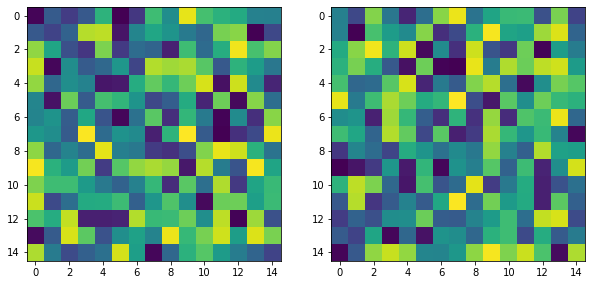

In [11]:
input_tensor_np = np.random.rand(*[B, Nxy,Nxy,N_in])
input_tensor_np_90 = np.transpose(np.flip(input_tensor_np,2),[0,2,1,3])

f,axs = plt.subplots(1,2,figsize=(10,10))
plt.subplot(1,2,1);plt.imshow(input_tensor_np[0,:,:,0]);
plt.subplot(1,2,2);plt.imshow(input_tensor_np_90[0,:,:,0]);
plt.show()

### Pass the original random signal to the network and then its 90 degree rotated version

In [12]:
out_1,out_2 = session.run([l_1.outputs,l_2.outputs], feed_dict = {inputs_ph:input_tensor_np})
out_1_90,out_2_90 = session.run([l_1.outputs,l_2.outputs], feed_dict = {inputs_ph:input_tensor_np_90})

Let's compare the responses at the central pixel

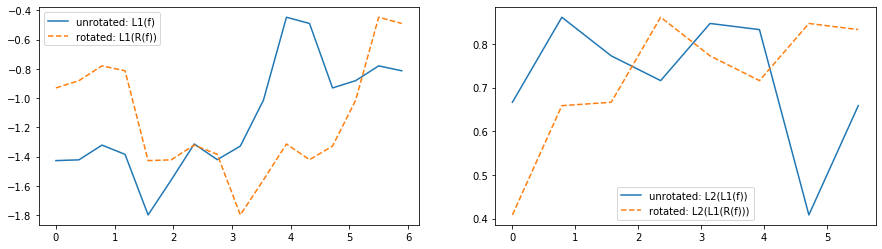

In [13]:
# Index of the central pixel for the output feature maps after each layer:
cindex_1 = int(l_1.outputs.shape[1])//2
cindex_2 = int(l_2.outputs.shape[1])//2
# Let's look at the first feature map in the batch, and the first channel:
bnr = 0
cnr = 0
# Plot the responses against the corresponding grid points
h_grid_1 = session.run(l_1.h_grid.grid)
h_grid_2 = session.run(l_2.h_grid.grid)
response_1 = out_1[bnr,cindex_1,cindex_1,:,0]
response_2 = out_2[bnr,cindex_2,cindex_2,:,0]
response_1_90 = out_1_90[bnr,cindex_1,cindex_1,:,0]
response_2_90 = out_2_90[bnr,cindex_2,cindex_2,:,0]
# Plot the results
f,axs = plt.subplots(1,2,figsize=(15,4))
plt.subplot(1,2,1);plt.plot(h_grid_1,response_1,label='unrotated: L1(f)');plt.plot(h_grid_1,response_1_90,'--',label='rotated: L1(R(f))');plt.legend()
plt.subplot(1,2,2);plt.plot(h_grid_2,response_2,label='unrotated: L2(L1(f))');plt.plot(h_grid_2,response_2_90,'--',label='rotated: L2(L1(R(f)))');plt.legend()
plt.show()

### From the equivariance scheme we know that a rotation corresponds to shift along the theta (h) axis, so let's shift the output of the unrotated input to see if the equivariance scheme indeed holds

From the following we see that the equivariance scheme indeed holds

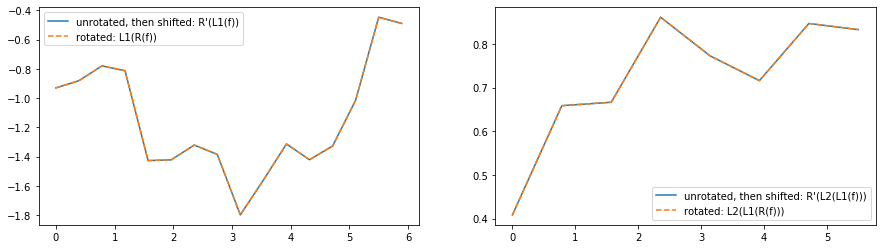

In [14]:
# Let's shift the response along the h-axis by 90 degrees (the corresponding nr of index positions to shift is found via list(h_grid_1).index(np.pi/2))
response_1_shifted = np.roll(out_1[bnr,cindex_1,cindex_1,:,0],list(h_grid_1).index(np.pi/2))
response_2_shifted = np.roll(out_2[bnr,cindex_2,cindex_2,:,0],list(h_grid_2).index(np.pi/2))
# Plot the result
f,axs = plt.subplots(1,2,figsize=(15,4))
plt.subplot(1,2,1);plt.plot(h_grid_1,response_1_shifted,label='unrotated, then shifted: R\'(L1(f))');plt.plot(h_grid_1,response_1_90,'--',label='rotated: L1(R(f))');plt.legend()
plt.subplot(1,2,2);plt.plot(h_grid_2,response_2_shifted,label='unrotated, then shifted: R\'(L2(L1(f)))');plt.plot(h_grid_2,response_2_90,'--',label='rotated: L2(L1(R(f)))');plt.legend()
plt.show()

### We can also see this from the feature maps. When the input is rotated, the same information is in the network, it just ends up rotated and in different rotation layers (different position on the h-axis)

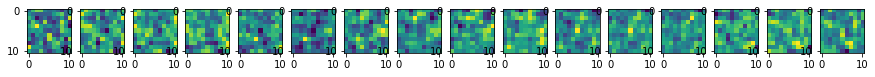

The unrotated input.


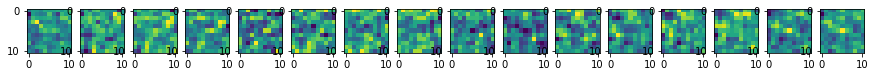

The 90-degree rotated input. Notice a shift of Ntheta/4 (=90/360*N_h) bins and a rotation of 90 of each plane.


In [15]:
#Plot
plt.subplots(1,N_h_1,figsize=(15,15))
for i in range(N_h_1):
    plt.subplot(1,N_h_1,i+1)
    plt.imshow(out_1[0,:,:,i,0])
plt.show()
print( 'The unrotated input.')
plt.subplots(1,N_h_1,figsize=(15,15))
for i in range(N_h_1):
    plt.subplot(1,N_h_1,i+1)
    plt.imshow(out_1_90[0,:,:,i,0])
plt.show()
print( 'The 90-degree rotated input. Notice a shift of Ntheta/4 (=90/360*N_h) bins and a rotation of 90 of each plane.')

## Finally let's have a look at the convolution kernels

In the lifting layer we convolve the input with a set of rotated convolution kernels. This is implemented by taking the base convolution kernel:

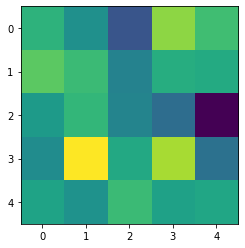

In [16]:
kern_1 = session.run(l_1.kernel())
plt.imshow(kern_1[:,:,0,0]);
plt.show()

And rotated via the action of the rotation group. This is implemented simply by calling kernel(h), which h the transformation that is applied to the kernel.

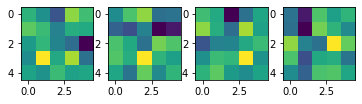

In [18]:
kern_1_0 = session.run(l_1.kernel(tf.constant([0],dtype=tf.float32)))
kern_1_45 = session.run(l_1.kernel(tf.constant([np.pi/4],dtype=tf.float32)))
kern_1_90 = session.run(l_1.kernel(tf.constant([np.pi/2],dtype=tf.float32)))
kern_1_135 = session.run(l_1.kernel(tf.constant([3*np.pi/4],dtype=tf.float32)))
plt.subplot(1,4,1);plt.imshow(kern_1_0[:,:,0,0])
plt.subplot(1,4,2);plt.imshow(kern_1_45[:,:,0,0])
plt.subplot(1,4,3);plt.imshow(kern_1_90[:,:,0,0])
plt.subplot(1,4,4);plt.imshow(kern_1_135[:,:,0,0])
plt.show()

## Same holds for the group convolution kernels, however these are 3-dimensional (x,y,h), and the rotation correspond to a planar rotation and a periodic shift over the h-axis

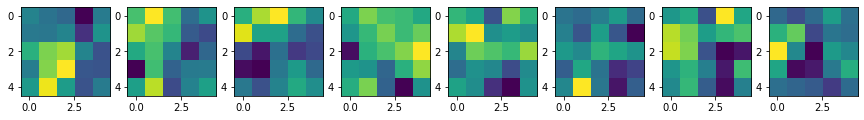

kernel(0): from left to right the planar kernels for each h


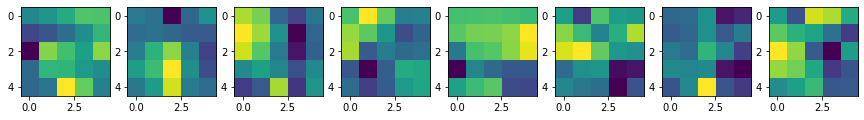

kernel(np.pi/8): from left to right the planar kernels for each h


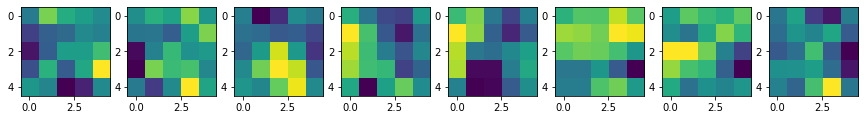

kernel(np.pi/4): from left to right the planar kernels for each h
and so on...


In [25]:
kern_2_0 = session.run(l_2.kernel())
plt.subplots(1,N_h_2,figsize=(15,15))
for i in range(N_h_2):
    plt.subplot(1,N_h_2,i+1)
    plt.imshow(kern_2_0[:,:,i,0,0])
plt.show()
print('kernel(0): from left to right the planar kernels for each h')
kern_2_225 = session.run(l_2.kernel(tf.constant([np.pi/8],dtype=tf.float32)))
plt.subplots(1,N_h_2,figsize=(15,15))
for i in range(N_h_2):
    plt.subplot(1,N_h_2,i+1)
    plt.imshow(kern_2_225[:,:,i,0,0])
plt.show()
print('kernel(np.pi/8): from left to right the planar kernels for each h')
kern_2_45 = session.run(l_2.kernel(tf.constant([np.pi/4],dtype=tf.float32)))
plt.subplots(1,N_h_2,figsize=(15,15))
for i in range(N_h_2):
    plt.subplot(1,N_h_2,i+1)
    plt.imshow(kern_2_45[:,:,i,0,0])
plt.show()
print('kernel(np.pi/4): from left to right the planar kernels for each h')
print('and so on...')